In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

Adding another head to A2C: a next-state predictor. If we can train the model to accurately predict its own next state and reward, we could use it to generate additional training data. Inspired by how humans do "mental practice" by imagining scenarios in their head. Like that study with basketball players taking free throws: Those who practiced mentally performed better, even with same amount of "live" data. This sort of sample efficiency isn't really necessary when we have access to an env simulator, eg Gym, but could be very helpful for robotics.

In [7]:
#N_STEPS = 5
SEED = 1
N_GAMES = 1000
N_ACTIONS = 2
N_INPUTS = 4

states = []
actions = []
rewards = []

env = gym.make('CartPole-v0')
env.seed(SEED)


[1]

In [8]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.linear1 = nn.Linear(N_INPUTS, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 64)
        
        self.actor = nn.Linear(64, N_ACTIONS)
        self.critic = nn.Linear(64, 1)
        self.predictor = nn.Linear(64, N_INPUTS)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        x = F.relu(x)
        
        return x
    
    def get_action_probs(self, x):
        x = self(x)
        action_probs = F.softmax(self.actor(x))
        return action_probs
    
    def evaluate_actions(self, x):
        x = self(x)
        action_probs = F.softmax(self.actor(x))
        state_values = self.critic(x)
        next_state = self.predictor(x)
        
        return action_probs, state_values, next_state
          

In [9]:
def test_model(model):
    score = 0
    done = False
    env = gym.make('CartPole-v0')
    state = env.reset()
    global action_probs
    while not done:
        score += 1
        s = torch.from_numpy(state).float().unsqueeze(0)
        
        action_probs = model.get_action_probs(Variable(s))
        
        _, action_index = action_probs.max(1)
        action = action_index.data[0] 
        next_state, reward, done, thing = env.step(action)
        state = next_state
        
    return score
    

In [10]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=3e-3)

Training. Score was  98
Training. Score was  116
Training. Score was  121
Training. Score was  103
Training. Score was  115
Training. Score was  107
Training. Score was  115
Training. Score was  115
Training. Score was  125
Training. Score was  121
Training. Score was  118
Training. Score was  112
Training. Score was  109
Training. Score was  99
Training. Score was  108
Training. Score was  98
Training. Score was  103
Training. Score was  95
Training. Score was  107
Training. Score was  97
Training. Score was  109
Training. Score was  114
Training. Score was  92
Training. Score was  100
Training. Score was  103
Training. Score was  96
Training. Score was  99
Training. Score was  91
Training. Score was  92
Training. Score was  91
Training. Score was  96
Training. Score was  102
Training. Score was  91
Training. Score was  96
Training. Score was  87
Training. Score was  95
Training. Score was  94
Training. Score was  92
Training. Score was  91
Training. Score was  106
Training. Score was

Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  200
Training. Score was  195
Training. Score was  197
Training. Score was  200
Training. Score was  180
Training. Score was  162
Training. Score was  170
Training. Score was  172
Training. Score was  173
Training. Score was  184
Training. Score was  186


Training. Score was  130
Training. Score was  148
Training. Score was  160
Training. Score was  155
Training. Score was  144
Training. Score was  143
Training. Score was  161
Training. Score was  159
Training. Score was  152
Training. Score was  130
Training. Score was  135
Training. Score was  164
Training. Score was  178
Training. Score was  173
Training. Score was  158
Training. Score was  144
Training. Score was  169
Training. Score was  137
Training. Score was  141
Training. Score was  140
Training. Score was  120
Training. Score was  143
Training. Score was  106
Training. Score was  127
Training. Score was  123
Training. Score was  128
Training. Score was  122
Training. Score was  120
Training. Score was  97
Training. Score was  98
Training. Score was  99
Training. Score was  108
Training. Score was  95
Training. Score was  99
Training. Score was  102
Training. Score was  105
Training. Score was  95
Training. Score was  109
Training. Score was  113
Training. Score was  103
Traini

Training. Score was  108
Training. Score was  113
Training. Score was  121


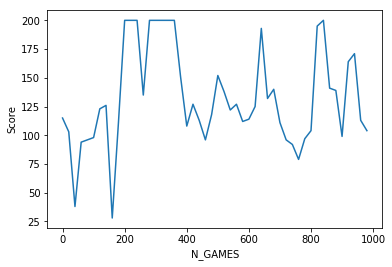

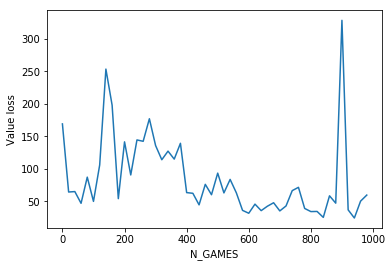

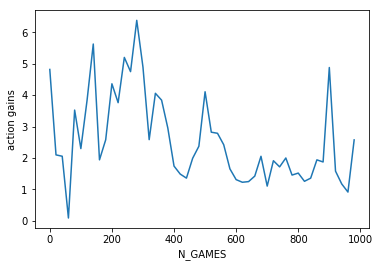

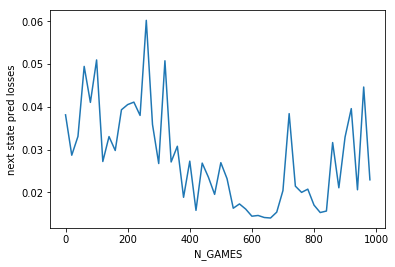

In [12]:
scores = []
num_games = []
value_losses = []
action_gains = []
state_pred_losses = []

for i in range(N_GAMES):
    
    del states[:]
    del actions[:]
    del rewards[:]
    
    state = env.reset() 
    done = False
    
    # act phase
    while not done:
        s = torch.from_numpy(state).float().unsqueeze(0)
        
        action_probs = model.get_action_probs(Variable(s))
        action = action_probs.multinomial().data[0][0]
        next_state, reward, done, _ = env.step(action)
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        state = next_state

    if True: #len(rewards) < 200: # only reflecting/training on episodes where a failure occured. No training
        # signal in perfect games. 
        # Reflect phase
        print("Training. Score was ", len(rewards))

        R = []
        rr = rewards
        rr.reverse()

        next_return = -30 #if len(rewards) < 200 else 1 # unnecessary now, should just be 0
        # punish failure hard

        for r in range(len(rr)):
            this_return = rr[r] + next_return * .9
            R.append(this_return)
            next_return = this_return
        R.reverse()

        rewards = R
        
        
        # taking only the last 20 states before failure. wow this really improves training
        """rewards = rewards[-20:]
        states = states[-20:]
        actions = actions[-20:]"""
        
        global ss
        ss = Variable(torch.FloatTensor(states))
        
        global next_states
        action_probs, state_values, next_states = model.evaluate_actions(ss)
        
        next_state_pred_loss = (ss[1:] - next_states[:-1]).pow(2).mean()

        action_log_probs = action_probs.log() 

        advantages = Variable(torch.FloatTensor(rewards)).unsqueeze(1) - state_values

        entropy = (action_probs * action_log_probs).sum(1).mean()

        a = Variable(torch.LongTensor(actions).view(-1,1))

        chosen_action_log_probs = action_log_probs.gather(1, a)

        action_gain = (chosen_action_log_probs * advantages).mean()

        value_loss = advantages.pow(2).mean()
        
        total_loss = value_loss/50.0 - action_gain - 0.0001*entropy + next_state_pred_loss
        #total_loss = next_state_pred_loss

        optimizer.zero_grad()

        total_loss.backward()

        nn.utils.clip_grad_norm(model.parameters(), 0.5)

        optimizer.step()
        
        #print("\nRewards", rewards, "\nState values",  state_values, )
        
    else: print("Not training, score of ", len(rewards))

    if i % 20 == 0:
        s = test_model(model)
        scores.append(s)
        num_games.append(i)

        action_gains.append(action_gain.data.numpy()[0])
        value_losses.append(value_loss.data.numpy()[0])
        state_pred_losses.append(next_state_pred_loss.data.numpy()[0])

        
plt.plot(num_games, scores)
plt.xlabel("N_GAMES")
plt.ylabel("Score")
#plt.title(EXP)
plt.show()

plt.plot(num_games, value_losses)
plt.xlabel("N_GAMES")
plt.ylabel("Value loss")
#plt.savefig("experiments/"+EXP_NAME+'/'+EXP)
plt.show()

plt.plot(num_games, action_gains)
plt.xlabel("N_GAMES")
plt.ylabel("action gains")
#plt.savefig("experiments/"+EXP_NAME+'/'+EXP)
plt.show()

plt.plot(num_games, state_pred_losses)
plt.xlabel("N_GAMES")
plt.ylabel("next state pred losses")
#plt.savefig("experiments/"+EXP_NAME+'/'+EXP)
plt.show()
    
    
env.close()



In [14]:
ss[1:]

Variable containing:
 0.0316 -0.1702  0.0060  0.2916
 0.0282  0.0249  0.0118  0.0008
 0.0287 -0.1704  0.0118  0.2971
 0.0253  0.0245  0.0178  0.0082
 0.0258 -0.1708  0.0179  0.3064
 0.0224  0.0240  0.0240  0.0195
 0.0229 -0.1714  0.0244  0.3196
 0.0195  0.0233  0.0308  0.0348
 0.0199 -0.1722  0.0315  0.3370
 0.0165  0.0225  0.0383  0.0544
 0.0169 -0.1732  0.0393  0.3589
 0.0135  0.0213  0.0465  0.0789
 0.0139 -0.1744  0.0481  0.3859
 0.0104  0.0200  0.0558  0.1088
 0.0108 -0.1759  0.0580  0.4185
 0.0073  0.0184  0.0664  0.1447
 0.0077  0.2125  0.0693 -0.1264
 0.0119  0.0164  0.0667  0.1873
 0.0122  0.2106  0.0705 -0.0836
 0.0164  0.0145  0.0688  0.2305
 0.0167  0.2086  0.0734 -0.0397
 0.0209  0.0125  0.0726  0.2752
 0.0212  0.2065  0.0781  0.0063
 0.0253  0.0103  0.0783  0.3226
 0.0255  0.2043  0.0847  0.0556
 0.0296  0.3981  0.0858 -0.2092
 0.0375  0.2018  0.0816  0.1092
 0.0416  0.3957  0.0838 -0.1566
 0.0495  0.1995  0.0807  0.1613
 0.0535  0.3934  0.0839 -0.1049
 0.0613  0.1971  0.

In [15]:
next_states[:-1]

Variable containing:
-0.0282 -0.2159  0.1088  0.2822
-0.0438 -0.0301  0.0673  0.1269
-0.0138 -0.1839  0.1050  0.2868
-0.0552  0.0089  0.0710  0.1000
 0.0010 -0.1455  0.0999  0.2937
-0.0712  0.0453  0.0752  0.0700
 0.0139 -0.1041  0.0923  0.3009
-0.0813  0.0921  0.0783  0.0390
 0.0294 -0.0444  0.0846  0.2883
-0.0809  0.1521  0.0791  0.0069
 0.0382  0.0118  0.0779  0.2578
-0.0657  0.2303  0.0805 -0.0278
 0.0424  0.0591  0.0706  0.2136
-0.0706  0.2853  0.0836 -0.0151
 0.0480  0.0880  0.0653  0.1612
-0.0334  0.3716  0.0826  0.0179
 0.0415  0.0939  0.0659  0.1038
-0.0210 -0.0769  0.1022  0.2198
-0.0511  0.1426  0.0794  0.0460
 0.0282  0.0447  0.0878  0.2325
-0.0719  0.2486  0.0831 -0.0217
 0.0569  0.1673  0.0777  0.2019
-0.0440  0.3708  0.0846 -0.0706
 0.0479  0.2102  0.0704  0.1462
-0.0075  0.4581  0.0796 -0.0166
 0.0686  0.2579  0.0673  0.0709
-0.0121  0.0161  0.1030  0.1711
 0.0082  0.2589  0.0747  0.0336
 0.0248  0.1434  0.0866  0.1806
 0.0102  0.4028  0.0840 -0.0437
 0.0687  0.2833  0.

1.6.18 

Only taking last 20 frames really helps training. Otherwise spiky up and down, presumably bc interesting data is overpowered by no-signal data.

Adding in next frame prediction.

Simply adding next frame prediction loss to total loss doesn't seem to impede training (haven't tested scientifically)

value loss is of much higher magnitude than other losses. Fiddling with the weights to see if it speeds training.

Divide value loss by 50. Result: Doesn't seem to affect training? haven't tested scientifically. Investigate further.

Predictor is training, though not perfectly. Actor Critic learns too fast to allow proper tuning (bc we're not training on batches w no failure). Let's include only prediction loss and see how good a predictor we can get.

Only updating based on predictor loss. This seems to improve score? How would that be possible? Restart kernal and try again. OK, verified that it does NOT improve scores, whew.

Training on only policy loss blows up gradients. Try again with lower LR.

Training on only value loss score does NOT improve scores. Thought it did but restarted kernal and it didn't. wtf maybe it does... OK it does. Seems to even off at around 100, though extremely variable. First goes up to 100 consistently, then alternates btwn 100 and 10 ish. Investigate further

Training on predictor only does NOT improve score. It does of course improve predictor substantially. To be truly valuable, though, it needs to predict more states than just those directly before failure. 

Predictor loss decreases to .01 after 2000 games. 

TODO: 
1) try training weights for total loss composition
2) add head to model to also predict rewards
3) Use predictor to generate imagined data. Train on this data and see what it does to scores.




